<a href="https://colab.research.google.com/github/kao99/HLIN505/blob/master/Weather_forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Weather forecasting LSTM


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [8]:
import os

base_dir = '/root/.keras/datasets/jena_climate_2009_2016_extracted'
print(os.listdir(base_dir))
# ➜ ['jena_climate_2009_2016.csv']

csv_path = os.path.join(base_dir, 'jena_climate_2009_2016.csv')
df = pd.read_csv(csv_path)


['jena_climate_2009_2016.csv']


In [11]:
df.head

<bound method NDFrame.head of                   Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
0       01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90   
1       01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28   
2       01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31   
3       01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07   
4       01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04   
...                     ...       ...       ...       ...          ...   
420546  31.12.2016 23:20:00   1000.07     -4.05    269.10        -8.13   
420547  31.12.2016 23:30:00    999.93     -3.35    269.81        -8.06   
420548  31.12.2016 23:40:00    999.82     -3.16    270.01        -8.21   
420549  31.12.2016 23:50:00    999.81     -4.23    268.94        -8.53   
420550  01.01.2017 00:00:00    999.82     -4.82    268.36        -8.42   

        rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
0        93.30          3.33          3.11          0.22       1.94   
1        93.40          3.23          3.02          0.21       1.89   
2        93.90          3.21          3.01          0.20       1.88   
3        94.20          3.26          3.07          0.19       1.92   
4        94.10          3.27          3.08          0.19       1.92   
...        ...           ...           ...           ...        ...   
420546   73.10          4.52          3.30          1.22       2.06   
420547   69.71          4.77          3.32          1.44       2.07   
420548   67.91          4.84          3.28          1.55       2.05   
420549   71.80          4.46          3.20          1.26       1.99   
420550   75.70          4.27          3.23          1.04       2.01   

        H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0                  3.12       1307.75      1.03           1.75     152.3  
1                  3.03       1309.80      0.72           1.50     136.1  
2                  3.02       1310.24      0.19           0.63     171.6  
3                  3.08       1309.19      0.34           0.50     198.0  
4                  3.09       1309.00      0.32           0.63     214.3  
...                 ...           ...       ...            ...       ...  
420546             3.30       1292.98      0.67           1.52     240.0  
420547             3.32       1289.44      1.14           1.92     234.3  
420548             3.28       1288.39      1.08           2.00     215.2  
420549             3.20       1293.56      1.49           2.16     225.8  
420550             3.23       1296.38      1.23           1.96     184.9  

[420551 rows x 15 columns]>

In [13]:
#df = pd.read_csv(csv_path)

Let's take a glance at the data.

## The weather dataset


This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003.

In [12]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [14]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [15]:
TRAIN_SPLIT = 300000

Setting seed to ensure reproducibility.

In [16]:
tf.random.set_seed(13)

In [17]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

,T (degC)
Date Time,
01.01.2009 00:10:00,-8.02
01.01.2009 00:20:00,-8.41
01.01.2009 00:30:00,-8.51
01.01.2009 00:40:00,-8.31
01.01.2009 00:50:00,-8.27


array([<Axes: xlabel='Date Time'>], dtype=object)

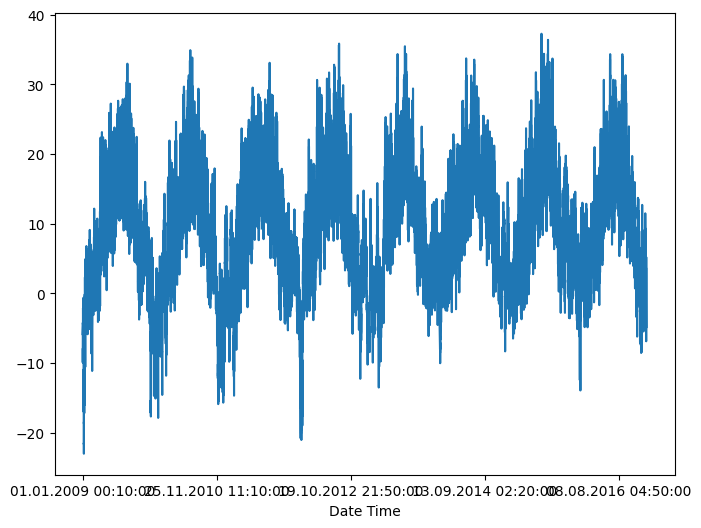

In [18]:
uni_data.plot(subplots=True)

In [19]:
uni_data = uni_data.values

In [20]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's normalize the data.

In [22]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step.

In [23]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

In [24]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.30036851]
 [-1.30559689]
 [-1.3069375 ]
 [-1.30425628]
 [-1.30372003]
 [-1.30077069]
 [-1.29500607]
 [-1.29500607]
 [-1.29889384]
 [-1.30586501]
 [-1.31028902]
 [-1.31189775]
 [-1.31149557]
 [-1.31122745]
 [-1.30894841]
 [-1.30894841]
 [-1.30948466]
 [-1.31095933]
 [-1.31136151]
 [-1.31270212]]

 Target temperature to predict
-1.3127021180821683


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [25]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [26]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

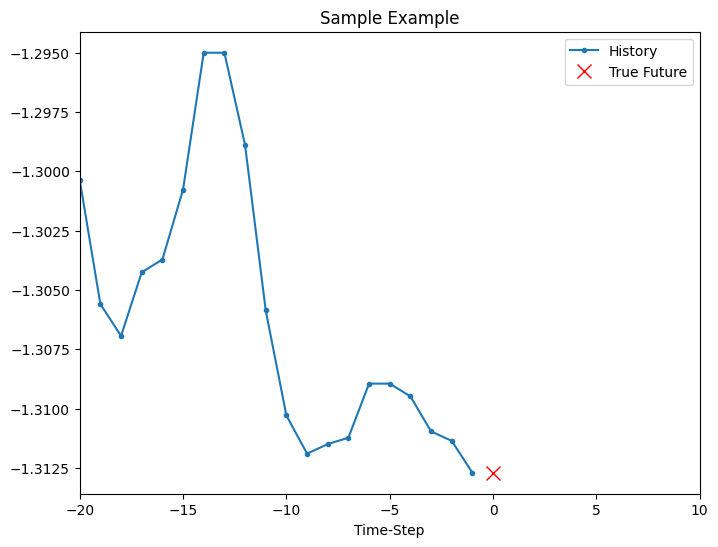

In [27]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [28]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

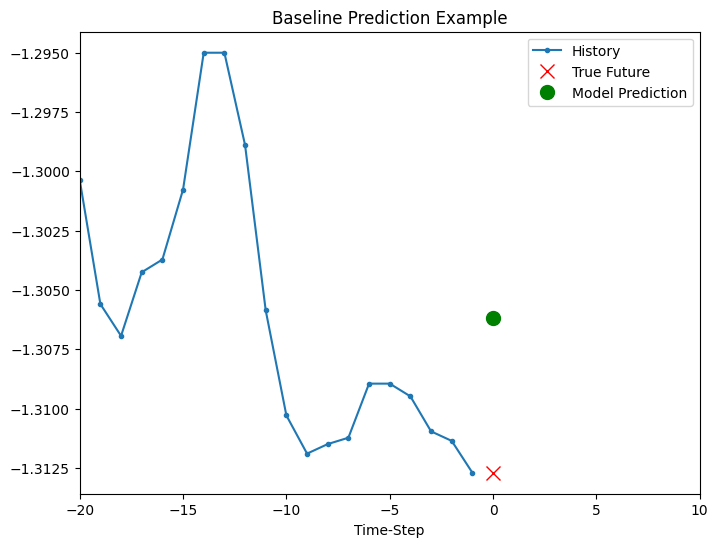

In [29]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

In [30]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far.

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [31]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Let's make a sample prediction, to check the output of the model.

In [32]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
(256, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [33]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2146 - val_loss: 0.0171
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0090 - val_loss: 0.0062
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0074 - val_loss: 0.0056
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0061 - val_loss: 0.0044
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0056 - val_loss: 0.0038
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0046 - val_loss: 0.0045


#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


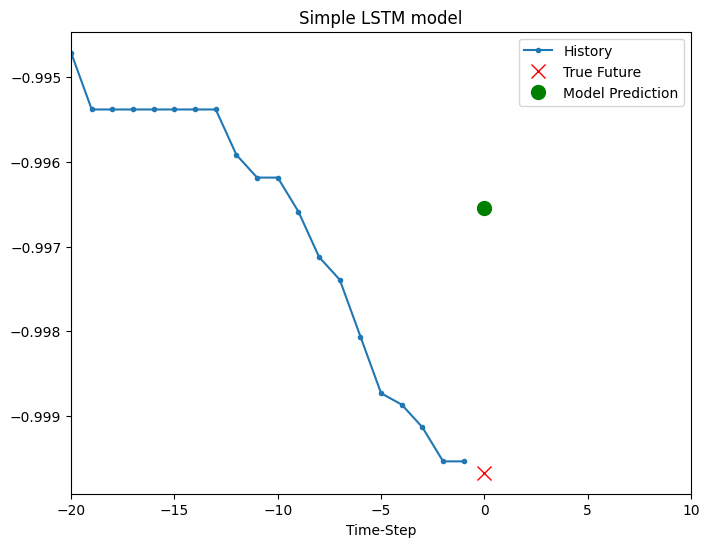

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


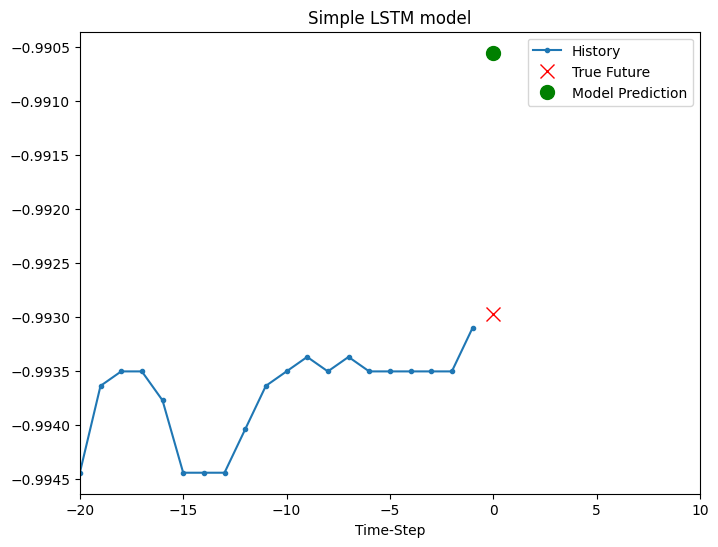

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


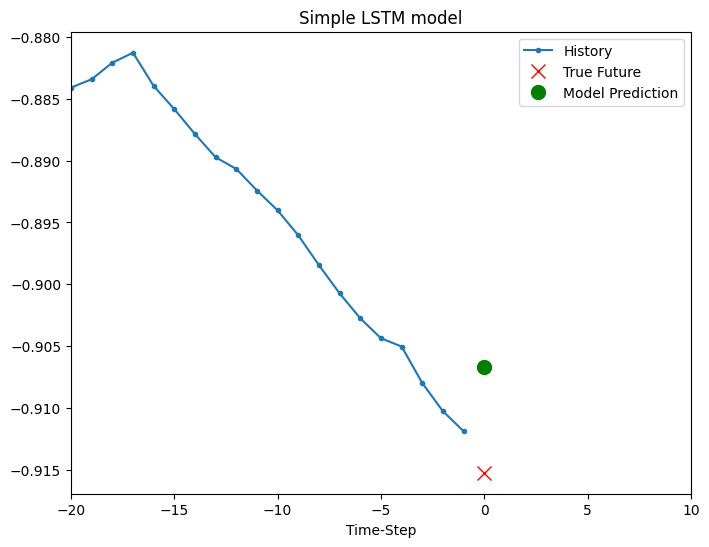

In [34]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density.

To use more features, add their names to this list.

In [35]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [36]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Let's have a look at how each of these features vary across time.

array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

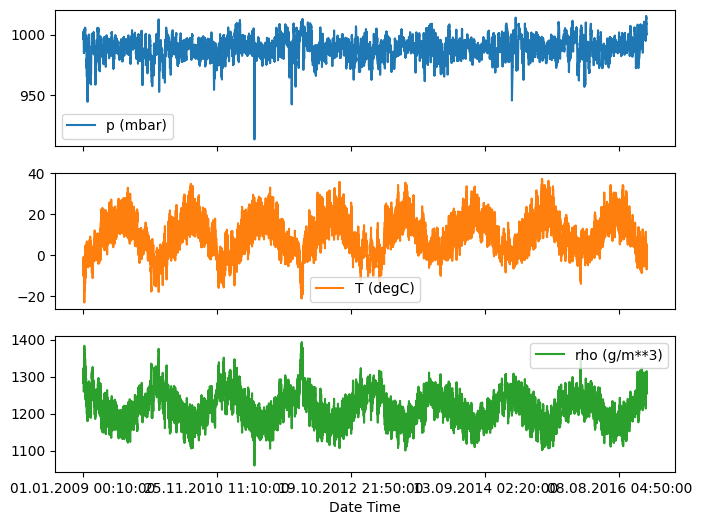

In [37]:
features.plot(subplots=True)

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [38]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [39]:
dataset = (dataset-data_mean)/data_std

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [40]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [41]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

The network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

Let's look at a single data-point.


In [42]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [43]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [44]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Let's check out a sample prediction.

In [45]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
(256, 1)


In [46]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.4030 - val_loss: 0.2554
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2667 - val_loss: 0.2378
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2659 - val_loss: 0.2441
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2605 - val_loss: 0.2370
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2186 - val_loss: 0.2269
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2413 - val_loss: 0.2534
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2420 - val_loss: 0.2573
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2380 - val_loss: 0.2540
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2440 - val_loss: 0.2463
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2515 - val_loss: 0.2244


In [47]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

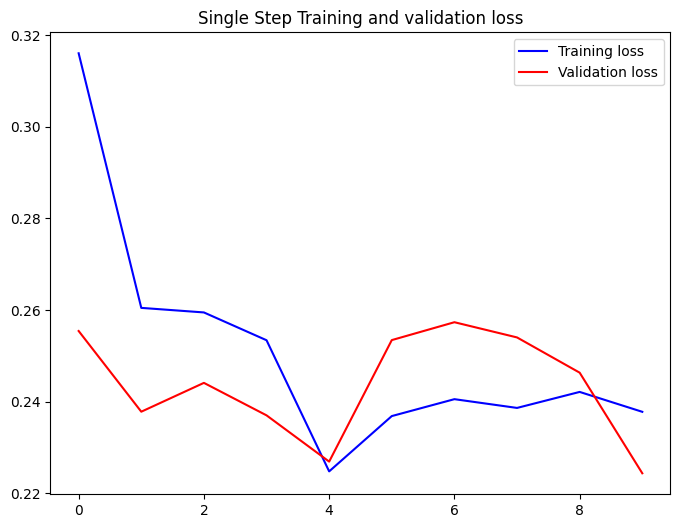

In [48]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction).

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


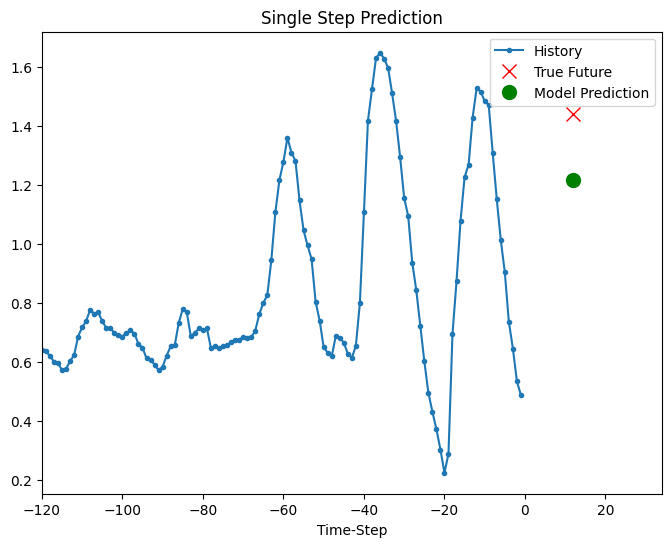

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


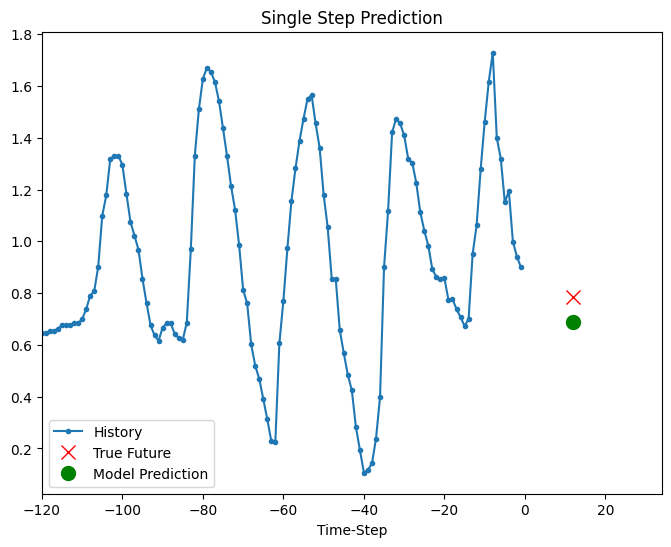

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


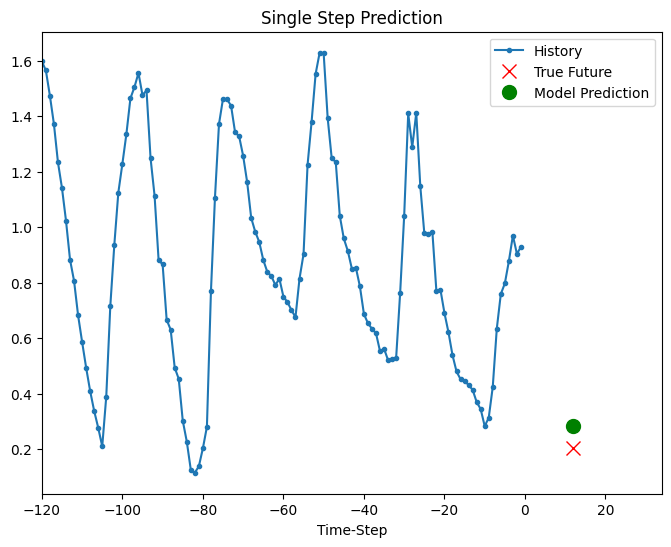

In [49]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [50]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [51]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [52]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [53]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

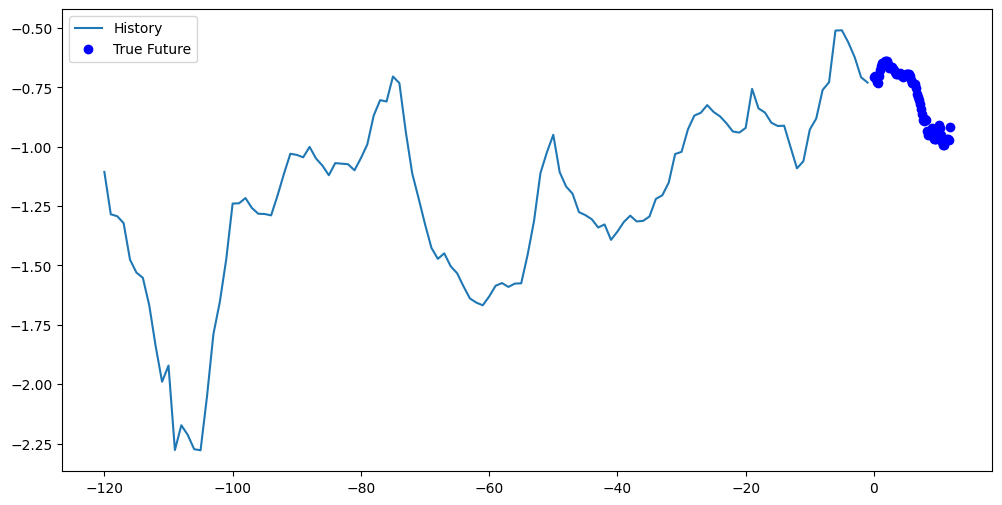

In [54]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [55]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [56]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
(256, 72)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - loss: 0.6519 - val_loss: 0.2918
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - loss: 0.3413 - val_loss: 0.2772
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - loss: 0.3391 - val_loss: 0.2476
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 183ms/step - loss: 0.2646 - val_loss: 0.2227
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - loss: 0.2040 - val_loss: 0.2147
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 208ms/step - loss: 0.2667 - val_loss: 0.2183
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - loss: 0.2132 - val_loss: 0.2124
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - loss: 0.2062 - val_loss: 0.2027
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - loss: 0.2107 - val_loss: 0.2011
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - loss: 0.2058 - val_loss: 0.1928


In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])